In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv(r'C:\Users\berna\etl_project\transform\properties_cleaned_final.csv')

In [23]:
df.columns

Index(['price', 'price_category', 'price_per_m2', 'area_util', 'quartos',
       'banheiros', 'vagas', 'neighborhood', 'city', 'state', 'cep',
       'scraped_date'],
      dtype='object')

In [ ]:
def identify_outliers(df):

    # Copy dataframe to avoid modifying original
    df_analysis = df.copy()
    
    # Numeric columns for analysis
    numeric_columns = ['price', 'price_per_m2', 'area_util', 
                      'quartos', 'banheiros', 'vagas']
    
    def get_outliers_zscore(data, threshold=3):
        """Identifies outliers using Z-score"""
        data_clean = data.dropna()
        if len(data_clean) == 0:
            return pd.Series()
        
        z_scores = np.abs(stats.zscore(data_clean))
        return data_clean[z_scores > threshold]
    
    def get_outliers_iqr(data):
        """Identifies outliers using IQR"""
        data_clean = data.dropna()
        if len(data_clean) == 0:
            return pd.Series()
        
        Q1 = data_clean.quantile(0.25)
        Q3 = data_clean.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)]
    
    outlier_report = {}
    
    for column in numeric_columns:
        if column in df_analysis.columns:
            data = df_analysis[column]
            data_clean = data.dropna()
            
            if len(data_clean) > 0:
                stats_dict = {
                    'mean': data_clean.mean(),
                    'median': data_clean.median(),
                    'std': data_clean.std(),
                    'min': data_clean.min(),
                    'max': data_clean.max(),
                    'count': len(data_clean),
                    'null_count': data.isnull().sum()
                }
                
                outliers_zscore = get_outliers_zscore(data)
                outliers_iqr = get_outliers_iqr(data)
                
                if len(data_clean) >= 100:
                    upper_limit = data_clean.quantile(0.99)
                    lower_limit = data_clean.quantile(0.01)
                else:
                    upper_limit = data_clean.max()
                    lower_limit = data_clean.min()
                
                outlier_dict = {
                    'statistics': stats_dict,
                    'outliers_count_zscore': len(outliers_zscore),
                    'outliers_count_iqr': len(outliers_iqr),
                    'outliers_percentage_zscore': (len(outliers_zscore) / len(data_clean)) * 100,
                    'outliers_percentage_iqr': (len(outliers_iqr) / len(data_clean)) * 100,
                    'suggested_upper_limit': upper_limit,
                    'suggested_lower_limit': lower_limit
                }
                
                outlier_report[column] = outlier_dict
                
    return outlier_report

def remove_outliers(df):
    """
    Removes outliers based on predefined limits
    """
    df_clean = df.copy()
    
    # Define limits based on domain knowledge and data analysis
    limits = {
        'price': {
            'min': 100000,    # Minimum reasonable price for a property
            'max': 5000000    # 99th percentile rounded
        },
        'area_util': {
            'min': 15,        # Minimum for studio apartments
            'max': 1000       # Reasonable limit for residential properties
        },
        'quartos': {
            'min': 1,         # Minimum for studio
            'max': 5          # Maximum identified
        },
        'banheiros': {
            'min': 1,         # Minimum reasonable
            'max': 5          # Maximum identified
        },
        'vagas': {
            'min': 0,         # May have no parking
            'max': 5          # Maximum reasonable
        },
        'price_per_m2': {
            'min': 1000,      # Minimum reasonable per m²
            'max': 25000      # Upper limit identified
        }
    }
    
    print("Starting outlier removal...")
    print(f"Initial records: {len(df_clean)}")
    
    # Remove records with zero price or area
    df_clean = df_clean[df_clean['price'] > 0]
    df_clean = df_clean[df_clean['area_util'] > 0]
    
    # Apply limits
    for column, limit in limits.items():
        before_count = len(df_clean)
        df_clean = df_clean[
            (df_clean[column] >= limit['min']) & 
            (df_clean[column] <= limit['max']) |
            (df_clean[column].isna())
        ]
        removed = before_count - len(df_clean)
        print(f"\nColumn {column}:")
        print(f"  Removed: {removed} records")
        print(f"  Lower limit: {limit['min']}")
        print(f"  Upper limit: {limit['max']}")
    
    # Recalculate price per m² after cleaning
    df_clean['price_per_m2'] = df_clean['price'] / df_clean['area_util']
    
    print("\nFinal summary:")
    print(f"Initial records: {len(df)}")
    print(f"Records after cleaning: {len(df_clean)}")
    print(f"Total removed: {len(df) - len(df_clean)}")
    print(f"Percentage kept: {(len(df_clean)/len(df))*100:.2f}%")
    
    return df_clean

def plot_distributions(df_cleaned):
    """
    Plots distribution of cleaned data
    """
    numeric_cols = ['price', 'area_util', 'quartos', 'banheiros', 'vagas', 'price_per_m2']
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df_cleaned, x=col)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_distributions(df_cleaned):
    """
    Plots distribution of cleaned data
    """
    numeric_cols = ['price', 'area_util', 'quartos', 'banheiros', 'vagas', 'price_per_m2']
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df_cleaned, x=col)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [26]:
def analyze_data_distribution(df_original, df_cleaned):
    """
    Analyzes data distribution before and after cleaning
    """
    numeric_columns = ['price', 'area_util', 'quartos', 'banheiros', 
                      'vagas', 'price_per_m2']
    
    for column in numeric_columns:
        if column in df_original.columns and column in df_cleaned.columns:
            print(f"\nAnalysis of {column}:")
            print("\nBefore cleaning:")
            print(df_original[column].describe())
            print("\nAfter cleaning:")
            print(df_cleaned[column].describe())


In [27]:
def clean_and_analyze_data(df):
    """
    Main function to clean and analyze the data
    """
    # 1. First, analyze outliers
    print("Analyzing outliers...")
    outlier_report = identify_outliers(df)
    
    # 2. Remove outliers
    print("\nRemoving outliers...")
    df_cleaned = remove_outliers(df)
    
    # 3. Analyze distributions
    print("\nAnalyzing distributions...")
    analyze_data_distribution(df, df_cleaned)
    
    # 4. Plot distributions
    print("\nPlotting distributions...")
    plot_distributions(df_cleaned)
    
    return df_cleaned

Analyzing outliers...

Removing outliers...
Starting outlier removal...
Initial records: 59789

Column price:
  Removed: 2892 records
  Lower limit: 100000
  Upper limit: 5000000

Column area_util:
  Removed: 554 records
  Lower limit: 15
  Upper limit: 1000

Column quartos:
  Removed: 0 records
  Lower limit: 1
  Upper limit: 5

Column banheiros:
  Removed: 0 records
  Lower limit: 1
  Upper limit: 5

Column vagas:
  Removed: 0 records
  Lower limit: 0
  Upper limit: 5

Column price_per_m2:
  Removed: 1422 records
  Lower limit: 1000
  Upper limit: 25000

Final summary:
Initial records: 59789
Records after cleaning: 48333
Total removed: 11456
Percentage kept: 80.84%

Analyzing distributions...

Analysis of price:

Before cleaning:
count    5.863600e+04
mean     8.578158e+05
std      6.015340e+06
min      0.000000e+00
25%      2.500000e+05
50%      4.570000e+05
75%      8.561995e+05
max      5.000000e+08
Name: price, dtype: float64

After cleaning:
count    4.833300e+04
mean     7.8974

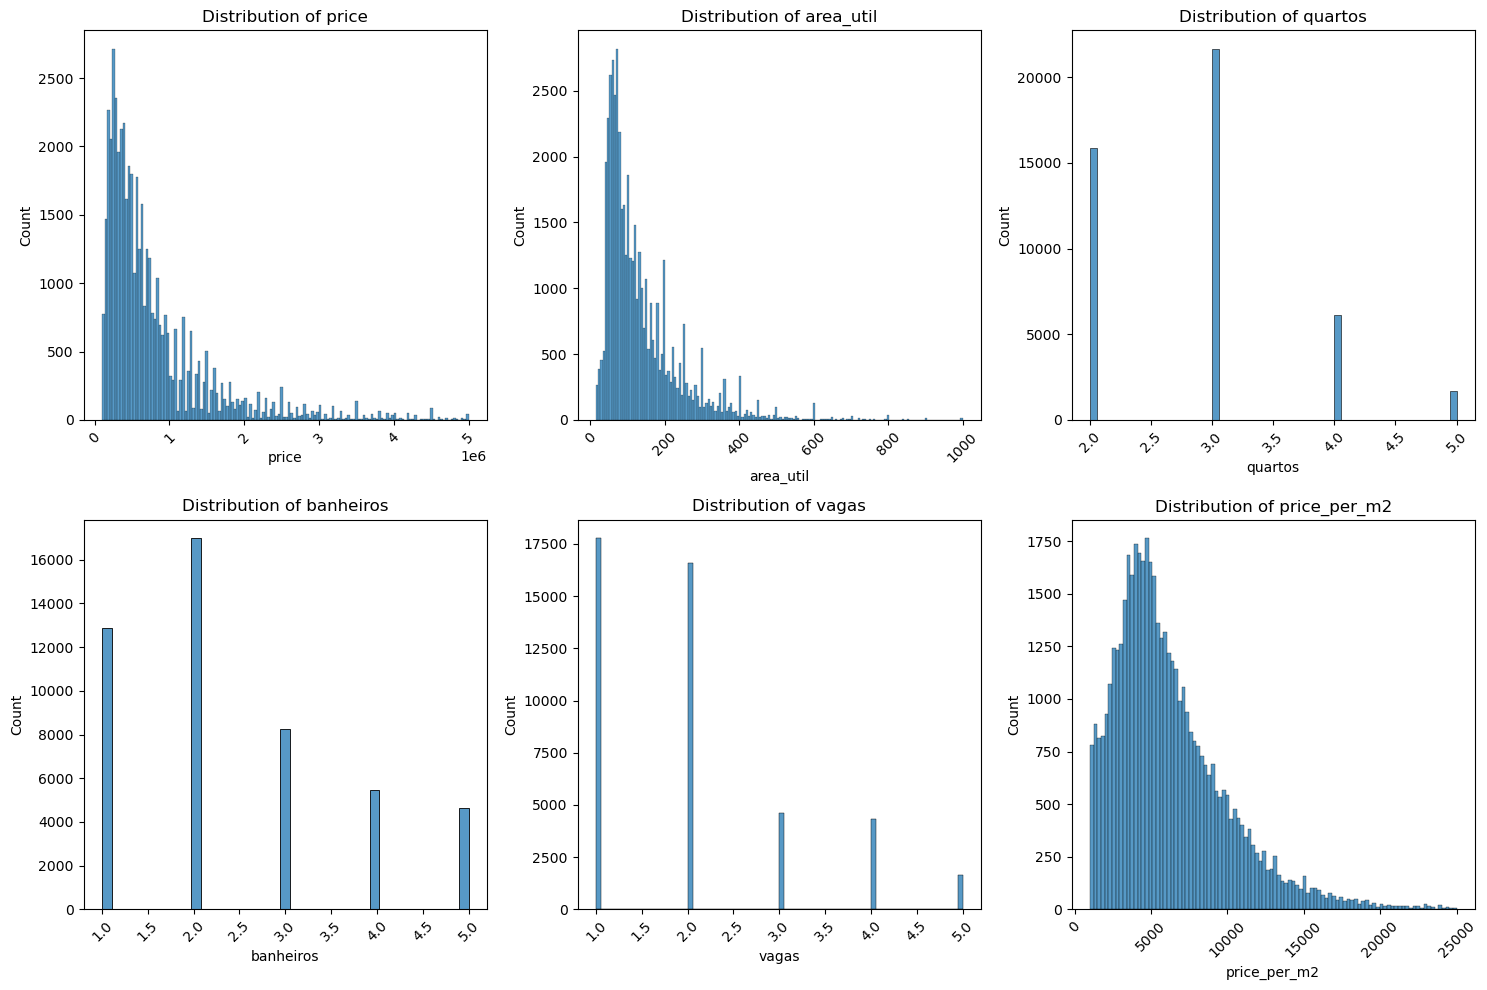

In [28]:
df_cleaned = clean_and_analyze_data(df)

In [29]:
df_cleaned.to_csv('properties_cleaned_no_outliers.csv', index=False)